<a href="https://colab.research.google.com/github/deepbiolab/data-science-hub/blob/main/tabular-model/tabpfn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TabPFN: A Comprehensive Guide and Hands-On-Demo

**Welcome to this enhanced and educational walkthrough of TabPFN!**

TabPFN is a novel machine learning model that is exceptionally fast and requires no hyperparameter tuning. It is particularly powerful for tabular data, which is a common data format in many real-world applications. This notebook will not only demonstrate how to use TabPFN but also provide clear explanations of the underlying concepts.

**What you will learn:**

* What TabPFN is and why it's a game-changer for tabular data.
* How to set up and run TabPFN on your local machine or using the client API.
* How to use TabPFN for both classification and regression tasks.
* A comparison of TabPFN's performance against other popular models like XGBoost and RandomForest.
* Advanced features of TabPFN, including handling text data, unsupervised learning, and model interpretability.

Let's get started!


## Table of Contents

1.  [Installation](#installation)
2.  [Backend Selection](#backend-selection)
3.  [Classification with TabPFN](#classification)
4.  [Regression with TabPFN](#regression)
5.  [Handling Text Data](#text-data)
6.  [Unsupervised Learning with TabPFN](#unsupervised-learning)
7.  [Model Interpretability](#interpretability)
8.  [Predictive Behavior](#behavior)


## Installation <a name="installation"></a>

First, we need to install the necessary libraries. This includes TabPFN itself, as well as other libraries for data manipulation and baseline model comparisons. If you are asked to restart the runtime after installation, please do so.


In [1]:
# Install Baselines for model comparison
!uv pip install catboost xgboost

# Install the datasets library for loading example data
!uv pip install datasets

# Install rich for better and more readable printing
!uv pip install rich

# Install the TabPFN Client and library
!uv pip install tabpfn tabpfn-client

# Install TabPFN extensions for additional functionalities
!git clone https://github.com/PriorLabs/tabpfn-extensions
!uv pip install -e tabpfn-extensions[all]

Using Python 3.11.13 environment at: /usr
Audited 2 packages in 81ms
Using Python 3.11.13 environment at: /usr
Audited 1 package in 78ms
Using Python 3.11.13 environment at: /usr
Audited 1 package in 73ms
Using Python 3.11.13 environment at: /usr
Audited 2 packages in 83ms
Using Python 3.11.13 environment at: /usr
Resolved 68 packages in 228ms
Uninstalled 1 package in 0.52ms
Installed 1 package in 1ms
 - tabpfn-extensions==0.1.0 (from file:///content/tabpfn-extensions)
 + tabpfn-extensions==0.1.0 (from git+https://github.com/PriorLabs/tabpfn-extensions.git@546f2ac0a2d93b39e994eaa9606ea57dfb95fa0e)
fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Using Python 3.11.13 environment at: /usr
Resolved 68 packages in 66ms
   Building tabpfn-extensions @ file:///content/tabpfn-extensions
   Building tabpfn-extensions @ file:///content/tabpfn-extensions
   Building tabpfn-extensions @ file:///content/tabpfn-extensions
   Building tabpfn-extensions @ file

**Now Restart the Runtime**

In [2]:
!uv pip install rtdl_num_embeddings
!uv pip install tabm

Using Python 3.11.13 environment at: /usr
Audited 1 package in 391ms
Using Python 3.11.13 environment at: /usr
Audited 1 package in 328ms


In [3]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import sklearn.preprocessing
import rtdl_num_embeddings
import tabm
from sklearn.base import BaseEstimator, RegressorMixin

class TabMRegressorWrapper(BaseEstimator, RegressorMixin):
    """Scikit-learn compatible wrapper for TabM regressor."""

    def __init__(self, n_epochs=100, patience=16, batch_size=256,
                 lr=2e-3, weight_decay=3e-4, random_state=None):
        self.n_epochs = n_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.random_state = random_state
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def fit(self, X, y):
        # Set random seeds for reproducibility
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
            np.random.seed(self.random_state)

        # Convert data to numpy if it's not already
        X = np.asarray(X).astype(np.float32)
        y = np.asarray(y).astype(np.float32)

        # Feature preprocessing
        self.preprocessor = sklearn.preprocessing.StandardScaler().fit(X)
        X_preprocessed = self.preprocessor.transform(X)

        # Label preprocessing
        self.y_mean = y.mean()
        self.y_std = y.std()
        y_preprocessed = (y - self.y_mean) / self.y_std

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X_preprocessed, device=self.device)
        y_tensor = torch.tensor(y_preprocessed, device=self.device)

        # Create embeddings
        n_num_features = X.shape[1]
        self.num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
            rtdl_num_embeddings.compute_bins(X_tensor, n_bins=48),
            d_embedding=16,
            activation=False,
            version='B',
        )

        # Create model
        self.model = tabm.TabM.make(
            n_num_features=n_num_features,
            cat_cardinalities=[],  # No categorical features
            d_out=1,  # Regression
            num_embeddings=self.num_embeddings,
        ).to(self.device)

        # Create optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )

        # Train the model
        train_size = len(X)
        epoch_size = math.ceil(train_size / self.batch_size)
        share_training_batches = True

        best_loss = float('inf')
        remaining_patience = self.patience
        best_model_state = None

        for epoch in range(self.n_epochs):
            # Create batch sequences
            batches = torch.randperm(train_size, device=self.device).split(self.batch_size)

            # Training loop
            self.model.train()
            epoch_loss = 0.0

            for batch_idx in batches:
                optimizer.zero_grad()

                # Forward pass
                output = self.model(X_tensor[batch_idx], None).squeeze(-1).float()

                # Flatten predictions for loss calculation
                output_flat = output.flatten(0, 1)
                y_batch = y_tensor[batch_idx]

                if share_training_batches:
                    y_batch = y_batch.repeat_interleave(self.model.backbone.k)
                else:
                    y_batch = y_batch.flatten(0, 1)

                # Calculate loss
                loss = F.mse_loss(output_flat, y_batch)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * len(batch_idx)

            # Calculate average loss for the epoch
            epoch_loss /= train_size

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = self.model.state_dict().copy()
                remaining_patience = self.patience
            else:
                remaining_patience -= 1

            if remaining_patience <= 0:
                break

        # Load the best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return self

    def predict(self, X):
        # Convert data to numpy if it's not already
        X = np.asarray(X).astype(np.float32)

        # Preprocess the input
        X_preprocessed = self.preprocessor.transform(X)
        X_tensor = torch.tensor(X_preprocessed, device=self.device)

        # Make predictions
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor, None).squeeze(-1).float()

        # Average predictions across ensemble members
        predictions = predictions.mean(dim=1)

        # Convert back to CPU numpy array
        predictions_np = predictions.cpu().numpy()

        # Scale predictions back to original scale
        predictions_np = predictions_np * self.y_std + self.y_mean

        return predictions_np

## Necessary Imports for the Notebook

Now that the libraries are installed, let's import all the necessary modules for this notebook.




In [6]:
# Standard Library Imports

# Data Science & Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Other ML Models
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.compose import make_column_selector, make_column_transformer

# Scikit-Learn: Data & Preprocessing
from sklearn.datasets import fetch_openml, load_breast_cancer

# Scikit-Learn: Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor

# TabPFN and Extensions
from tabpfn import TabPFNClassifier, TabPFNRegressor

try:
    from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
        AutoTabPFNClassifier,
    )
except ImportError:
    print("Warning: Could not import TabPFN extensions. Please restart the session.")

# Notebook UI/Display
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule

# This transformer will be used to handle categorical features for the baseline models
column_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_include=["object", "category"]),
    ),
    remainder="passthrough",
)

## Backend Selection <a name="backend-selection"></a>


TabPFN can be run in two ways: locally on your machine (if you have a GPU) or by using the TabPFN client, which sends the data to a server for computation.
In your project you would either use the local version (which requires a GPU) with :
```python
# Simple import for TabPFN
from tabpfn import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```

or the **client** API (which uses a remote server):

```python
# Simple import for TabPFN
from tabpfn_client import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```


For demonstration purposes, the cell below provides an interactive way to switch between those:


In [7]:
console = Console()

console.print(Panel.fit("[bold magenta]TabPFN Demo: Backend Selection[/bold magenta]"))
console.print("\nThis script can run TabPFN using one of two backends:")
console.print("  [bold]1. local:[/bold] Uses a local GPU (NVIDIA). Requires CUDA.")
console.print(
    "  [bold]2. client:[/bold] Uses the TabPFN API. Requires an internet connection and a free account."
)

backend = Prompt.ask(
    "\n[bold]Choose your backend[/bold]", choices=["client", "local"], default="client"
)

console.print(
    f"\n✅ You have selected the '[bold green]{backend}[/bold green]' backend."
)

console.print(Rule(f"[bold]Setting up [cyan]{backend}[/cyan] backend[/bold]"))

if backend == "local":
    console.print("Attempting local backend setup...")
    import torch

    if not torch.cuda.is_available():
        console.print(
            "[bold red]Error:[/bold red] GPU device not found. For fast training, please enable GPU.",
            style="red",
        )
        console.print(
            "In Colab: Go to [bold]Runtime -> Change runtime type -> Hardware accelerator -> GPU.[/bold]",
            style="yellow",
        )
        raise SystemError("GPU device not found.")
    console.print(
        "[bold green]✅ GPU is available.[/bold green] Importing local TabPFN library..."
    )
    from tabpfn import TabPFNClassifier, TabPFNRegressor

    console.print("[bold green]✅ TabPFN (local) imported successfully.[/bold green]")
elif backend == "client":
    console.print("Attempting client backend setup...")
    console.print("Importing TabPFN client library...")
    from tabpfn_client import TabPFNClassifier, TabPFNRegressor, init

    init()
    console.print("[bold green]✅ TabPFN (client) initialized.[/bold green]")

╭────────────────────────────────╮
│ TabPFN Demo: Backend Selection │
╰────────────────────────────────╯

This script can run TabPFN using one of two backends:

1. local: Uses a local GPU (NVIDIA). Requires CUDA.

2. client: Uses the TabPFN API. Requires an internet connection and a free account.

Choose your backend [client/local] (client):

local


✅ You have selected the 'local' backend.

──────────────────────────────────────────── Setting up local backend ─────────────────────────────────────────────

Attempting local backend setup...

✅ GPU is available. Importing local TabPFN library...

✅ TabPFN (local) imported successfully.

## Classification with TabPFN <a name="classification"></a>

Now, let's dive into a practical example of using TabPFN for a classification task. We will use the well-known Parkinson's Disease dataset. The goal is to predict the presence of Parkinson's disease based on various voice measurements.

We will compare TabPFN's performance against other popular machine learning models: RandomForest, XGBoost, and CatBoost. The performance metric we will use is the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) score.


In [4]:
# Parkinson's Disease dataset: Predict Parkinson's disease presence
# Features: Voice measurements (e.g., frequency, amplitude)
# Samples: 195 cases
df = fetch_openml("parkinsons")

X, y = df.data, df.target

# Print dataset description
display(Markdown(df["DESCR"]))

display(X)

**Author**:   
**Source**: UCI
**Please cite**: 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. BioMedical Engineering OnLine 2007, 6:23 (26 June 2007) 

* Abstract: 

Oxford Parkinson's Disease Detection Dataset

* Source:

The dataset was created by Max Little of the University of Oxford, in collaboration with the National Centre for Voice and Speech, Denver, Colorado, who recorded the speech signals. The original study published the feature extraction methods for general voice disorders.

* Data Set Information:
This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD. 

Further details are contained in the following reference -- if you use this dataset, please cite: 
Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).


* Attribute Information:

Matrix column entries (attributes): 
name - ASCII subject name and recording number 
MDVP:Fo(Hz) - Average vocal fundamental frequency 
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency 
MDVP:Flo(Hz) - Minimum vocal fundamental frequency 
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency 
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude 
NHR,HNR - Two measures of ratio of noise to tonal components in the voice 
status - Health status of the subject (one) - Parkinson's, (zero) - healthy 
RPDE,D2 - Two nonlinear dynamical complexity measures 
DFA - Signal fractal scaling exponent 
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

Downloaded from openml.org.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [5]:
# Alternative datasets (commented for reference):

# German Credit Fraud (ID: 31)
# Samples: 1,000
# Features: 20 (account info, credit history, employment)
# Target: Good/Bad credit risk
# df = fetch_openml(data_id=31)

# Cholesterol dataset: Predict cholesterol levels
# Features: Patient characteristics, medical measurements
# Samples: 303 patients
# Target: Cholesterol levels in mg/dl
# df = fetch_openml('cholesterol', version=2, as_frame=True)

# Heart Disease dataset (Statlog): Predict presence of heart disease
# Features: Clinical and test measurements
# Samples: 270 patients
# Target: Binary heart disease diagnosis
# df = fetch_openml("heart-statlog", version=1)

# Diabetes dataset: Predict diabetes presence
# Features: Medical measurements, patient history
# Samples: 768 patients
# Target: Binary diabetes diagnosis
# df = fetch_openml("diabetes", version=1)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Train and evaluate the TabPFN classifier
tabpfn_classifier = TabPFNClassifier(random_state=42)
tabpfn_classifier.fit(X_train, y_train)
y_pred_proba = tabpfn_classifier.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"TabPFN ROC AUC Score: {roc_auc:.4f}")

TabPFN ROC AUC Score: 0.9688


### Comparing TabPFN with Other Classifiers

To get a better sense of TabPFN's performance, let's compare it with other popular classification models using cross-validation. This will give us a more robust estimate of each model's performance.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s finished


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

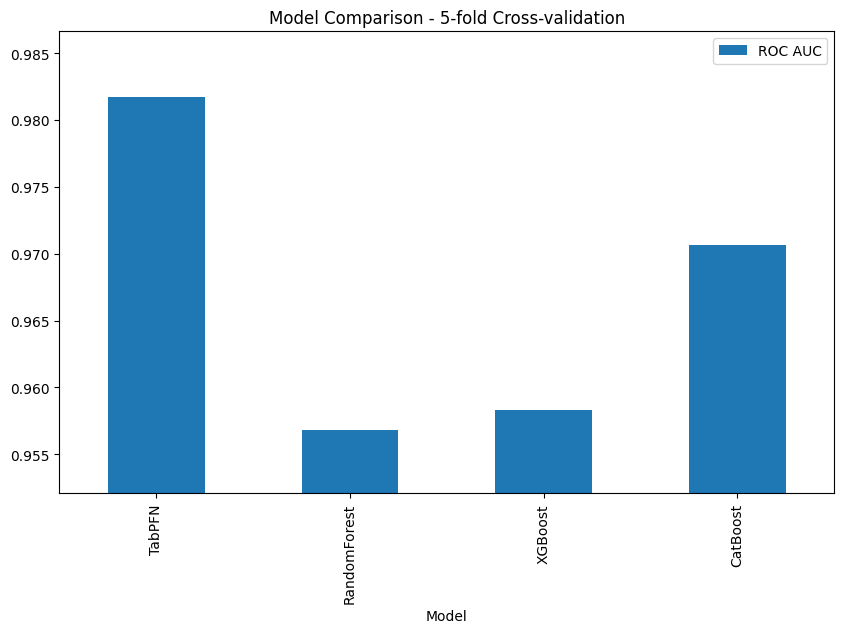

In [7]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Encode target labels to classes for baselines
le = LabelEncoder()
y = le.fit_transform(y)

# Define models
models = [
    ("TabPFN", TabPFNClassifier(random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            RandomForestClassifier(random_state=42),
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            XGBClassifier(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            CatBoostClassifier(random_state=42, verbose=0),
        ),
    ),
]

# Calculate scores
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
scoring = "roc_auc_ovr" if len(np.unique(y)) > 2 else "roc_auc"
scores = {
    name: cross_val_score(
        model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1
    ).mean()
    for name, model in models
}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=["Model", "ROC AUC"])
ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
ax.set_title("Model Comparison - 5-fold Cross-validation")

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /content/tabpfn-extensions/src/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-od3j1g5m.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier-od3j1g5m.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /content/tabpfn-extensions/src/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-llderlii.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier-llderlii.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(-0.96875), np.float64(-0.96875), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.9715909090909092), np.float64(-0.97159

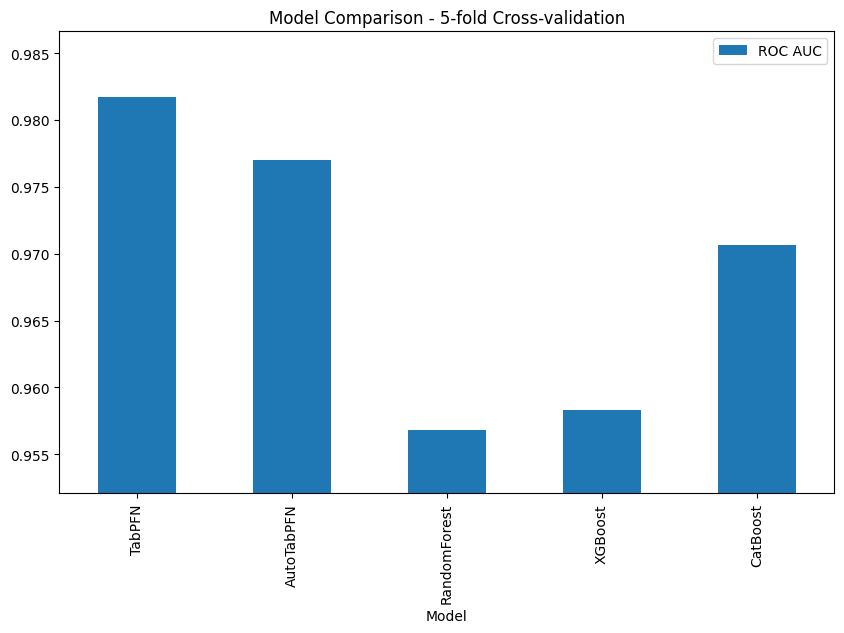

In [8]:
# Adding AutoTabPFN which is significantly slower but gives best results

if backend == "client":
    console.print(
        Panel(
            "[bold red]AutoTabPFN is skipped for the 'client' backend.[/bold red]\n\n"
            "Running this model via the API would lead to excessive usage and long wait times. ",
            title="[bold yellow]Warning",
            border_style="yellow",
        )
    )
else:
    # Encode target labels to classes for baselines
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Define models
    models = [
        ("TabPFN", TabPFNClassifier(random_state=42)),
        ("AutoTabPFN", AutoTabPFNClassifier(random_state=42)),
        (
            "RandomForest",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                RandomForestClassifier(random_state=42),
            ),
        ),
        (
            "XGBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                XGBClassifier(random_state=42),
            ),
        ),
        (
            "CatBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                CatBoostClassifier(random_state=42, verbose=0),
            ),
        ),
    ]

    # Calculate scores
    cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    scoring = "roc_auc_ovr" if len(np.unique(y)) > 2 else "roc_auc"
    scores = {
        name: cross_val_score(
            model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1
        ).mean()
        for name, model in models
    }

    # Plot results
    df = pd.DataFrame(list(scores.items()), columns=["Model", "ROC AUC"])
    ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
    ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
    ax.set_title("Model Comparison - 5-fold Cross-validation")

## Regression with TabPFN <a name="regression"></a>

Next, we'll explore how to use TabPFN for regression tasks. We will use the Boston Housing dataset, where the goal is to predict the median value of owner-occupied homes.

We will measure performance using the [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html), and again, we will compare TabPFN with other popular regression models.

In [8]:
# Load the Boston Housing dataset
df_boston = fetch_openml(data_id=531, as_frame=True)
X, y = df_boston.data, df_boston.target

# Display the dataset description and data
display(Markdown("### Boston Housing Dataset"))
display(Markdown(df_boston["DESCR"]))
display(X.head())

### Boston Housing Dataset

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
MEDV     Median value of owner-occupied homes in $1000's


Information about the dataset
CLASSTYPE: numeric
CLASSINDEX: last

Downloaded from openml.org.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [9]:
# Alternative datasets (commented for reference):

# Liver Disorders dataset
# Classification task: Predict liver disorder presence
# Features: Blood test results, alcohol consumption
# Samples: 345 patients
# Target: Binary liver disorder diagnosis
# df = fetch_openml("liver-disorders", version=1)

# Grid Stability dataset
# Regression task: Predict electrical grid stability
# Features: Power system measurements, grid parameters
# Samples: 10,000 simulations
# Target: Grid stability score
# df = fetch_openml(data_id=44973, as_frame=True)

# Concrete Compressive Strength dataset
# Regression task: Predict concrete strength
# Features: Concrete components (cement, water, aggregates)
# Samples: 1,030 concrete samples
# Target: Compressive strength in MPa
# df = fetch_openml(data_id=44959, as_frame=True)

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Train and evaluate the TabPFN regressor
tabpfn_regressor = TabPFNRegressor(random_state=42)
tabpfn_regressor.fit(X_train, y_train)
y_pred = tabpfn_regressor.predict(X_test)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"TabPFN RMSE: {rmse:.4f}")

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:101: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN RMSE: 2.6737


### Comparing TabPFN with Other Regressors

Now, let's see how TabPFN's regression performance stacks up against other models using cross-validation.


In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished
/usr/local/lib/python3.11/dist-packages/rtdl_num_embeddings.py:340: UserWarning: The 0-th feature has just two bin edges, which means only one bin. Strictly speaking, using a single bin for the piecewise-linear encoding should not break anything, but it is the same as using sklearn.preprocessing.MinMaxScaler
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rtdl_num_embeddings.py:340: UserWarning: The 0-th feature has just two bin edges, which means only one bin. Strictly speaking, using a single bin for the piecewise-linear encoding should not br

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation \n (Variance Explained - Larger is better)')

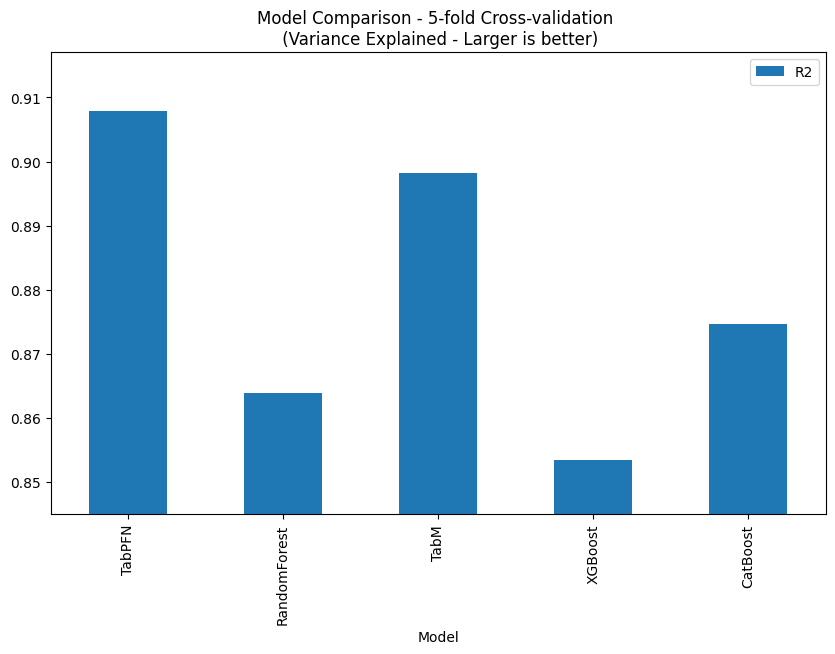

In [16]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ("TabPFN", TabPFNRegressor(random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            RandomForestRegressor(random_state=42),
        ),
    ),
    (
        "TabM",  # 新增TabM模型
        make_pipeline(
            column_transformer,
            TabMRegressorWrapper(random_state=42, n_epochs=200, patience=20)  # 设置较小的epochs数量以加快评估
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            XGBRegressor(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            CatBoostRegressor(random_state=42, verbose=0),
        ),
    ),
]

# Calculate scores
scoring = "r2"
cv = KFold(n_splits=3, random_state=42, shuffle=True)
scores = {
    name: cross_val_score(
        model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1
    ).mean()
    for name, model in models
}


# Plot results
df = pd.DataFrame(list(scores.items()), columns=["Model", "R2"])
ax = df.plot(x="Model", y="R2", kind="bar", figsize=(10, 6))
ax.set_ylim(df["R2"].min() * 0.99, df["R2"].max() * 1.01)
ax.set_title(
    "Model Comparison - 5-fold Cross-validation \n (Variance Explained - Larger is better)"
)

## Handling Text Data <a name="text-data"></a>

A powerful feature of the TabPFN server is its ability to handle text data directly, without the need for manual feature engineering. This simplifies the process of working with datasets that contain a mix of numerical and textual features.

**Note:** This feature is only available when using the 'client' backend.

In [12]:
if backend != "client":
    console.print(
        Panel(
            "[bold yellow]Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client' backend to run this section.[/bold yellow]",
            title="[bold yellow]Warning",
            border_style="yellow",
        )
    )
else:
    # We will use gdown to download the dataset
    !gdown --fuzzy "17bJekFGIAxbrdcBeBIvcyZjneweY581E"

    # Load the clothing review dataset
    # We restrict to 500 rows to make the example faster
    df_text = pd.read_csv("cloth.csv", index_col=0).dropna()[:500]

    # Define features and target
    y_text = df_text["Rating"]
    X_text = df_text.drop(columns=["Rating"])

    print("Text dataset loaded successfully!")
    display(X_text.head())

╭──────────────────────────────────────────────────── Warning ────────────────────────────────────────────────────╮
│ Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client'  │
│ backend to run this section.                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Comparing Text Handling

Now, let's compare how TabPFN handles text natively versus how a baseline model like RandomForest needs a specific text processing pipeline.

For baselines, we will create a pipeline that converts strings to ordinal features.

For TabPFN, we simply pass the raw data with the text column directly to the classifier.

In [18]:
if backend == "client":
    # Encode target labels to classes for baselines
    le = LabelEncoder()
    y_text = le.fit_transform(y_text)

    # Define models
    models = [
        ("TabPFN-Text", TabPFNClassifier(random_state=42)),
        (
            "TabPFN",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                TabPFNClassifier(random_state=42),
            ),
        ),
        (
            "RandomForest",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                RandomForestClassifier(random_state=42),
            ),
        ),
        (
            "XGBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                XGBClassifier(random_state=42),
            ),
        ),
        (
            "CatBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                CatBoostClassifier(random_state=42, verbose=0),
            ),
        ),
    ]

    # Calculate scores
    cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    scoring = "roc_auc_ovr" if len(np.unique(y_text)) > 2 else "roc_auc"
    scores = {
        name: cross_val_score(
            model, X_text, y_text, cv=cv, scoring=scoring, n_jobs=1, verbose=1
        ).mean()
        for name, model in models
    }

    # Plot results
    df = pd.DataFrame(list(scores.items()), columns=["Model", "ROC AUC"])
    ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
    ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
    ax.set_title("Model Comparison - 5-fold Cross-validation")

## Unsupervised Learning with TabPFN <a name="unsupervised-learning"></a>

TabPFN can also be used for unsupervised learning tasks like outlier detection and synthetic data generation. These features are available through the `tabpfn-extensions` library.


### Data Generation / Outlier Detection

100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


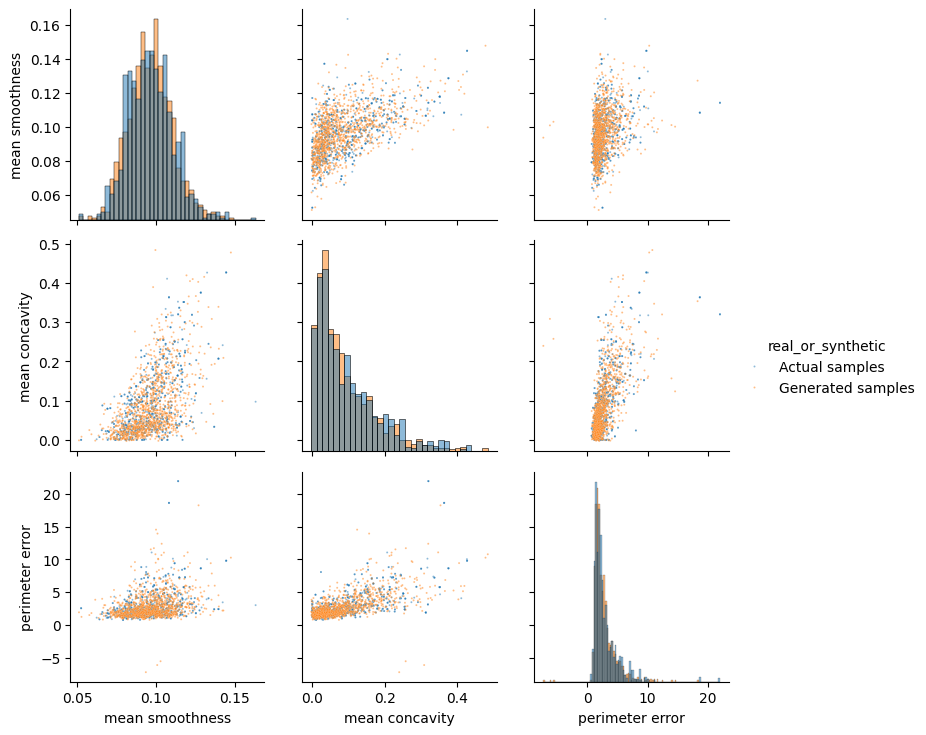

In [13]:
from tabpfn_extensions import unsupervised

# Load and prepare breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
feature_names = df["feature_names"]

# Initialize TabPFN models
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=TabPFNClassifier(), tabpfn_reg=TabPFNRegressor()
)

# Select features for synthetic data generation
# Example features: [mean texture, mean area, mean concavity]
feature_indices = [4, 6, 12]

# Run synthetic data generation experiment
experiment = unsupervised.experiments.GenerateSyntheticDataExperiment(
    task_type="unsupervised"
)

results = experiment.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=feature_names,
    temp=1.0,  # Temperature parameter for sampling
    n_samples=X.shape[0] * 2,  # Generate twice as many samples as original data
    indices=feature_indices,
)

### Outlier detection

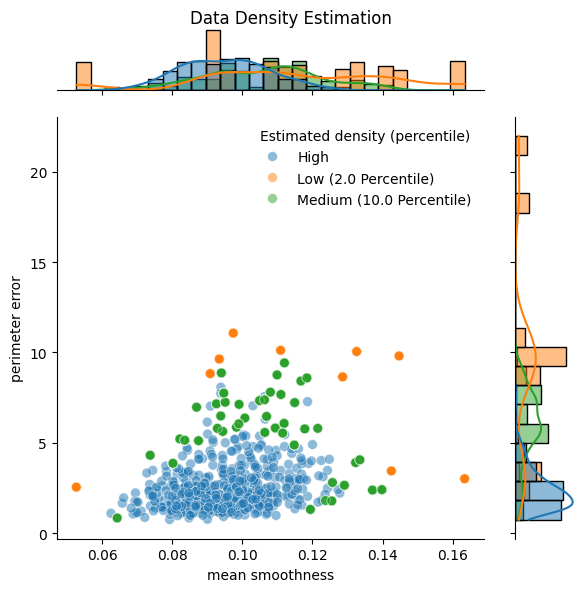

In [14]:
import torch
from sklearn.datasets import load_breast_cancer
from tabpfn_extensions import unsupervised

# Load data
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
attribute_names = df["feature_names"]

# Initialize models
clf = TabPFNClassifier(n_estimators=4)
reg = TabPFNRegressor(n_estimators=4)
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf, tabpfn_reg=reg
)

# Run outlier detection
exp_outlier = unsupervised.experiments.OutlierDetectionUnsupervisedExperiment(
    task_type="unsupervised"
)
results = exp_outlier.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=attribute_names,
    indices=[4, 12],  # Analyze features 4 and 12
)

## Model Interpretability <a name="interpretability"></a>

Understanding *why* a model makes certain predictions is crucial for building trust and for debugging. The `tabpfn-extensions` library provides tools for model interpretability. We'll look at SHAP (SHapley Additive exPlanations) values, which show the impact of each feature on a specific prediction.

### Shapley Values

Next, we'll use SHAP to understand our model's predictions. SHAP values break down a prediction to show the contribution of each feature, helping us see which factors are most influential for a given data point.


PermutationExplainer explainer: 51it [01:46,  2.27s/it]


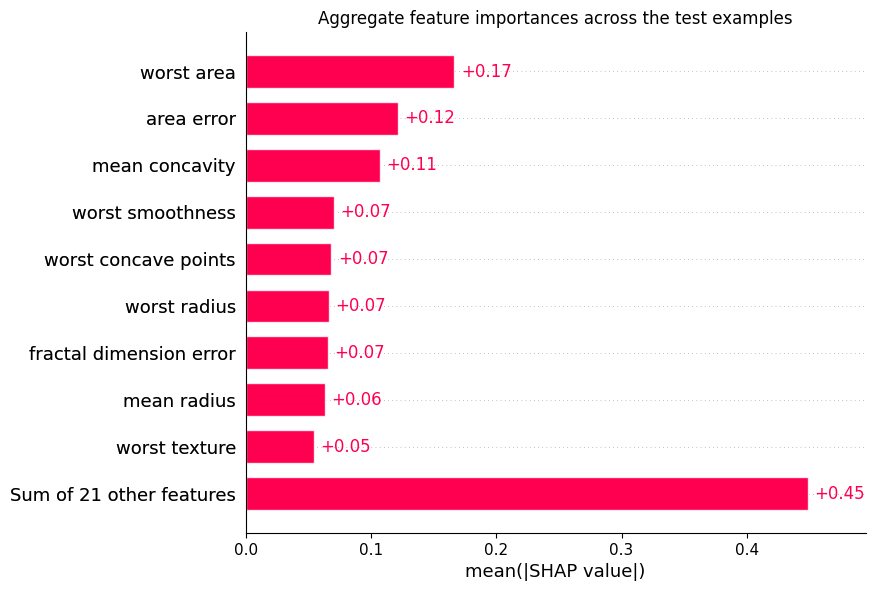

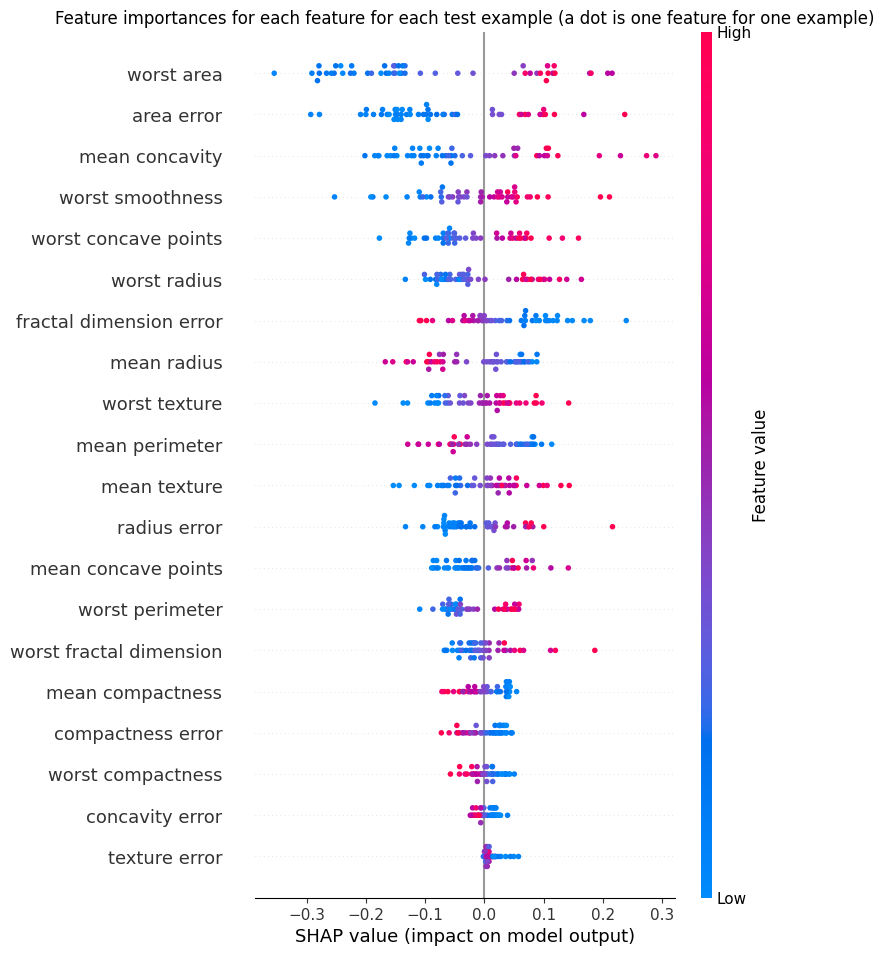

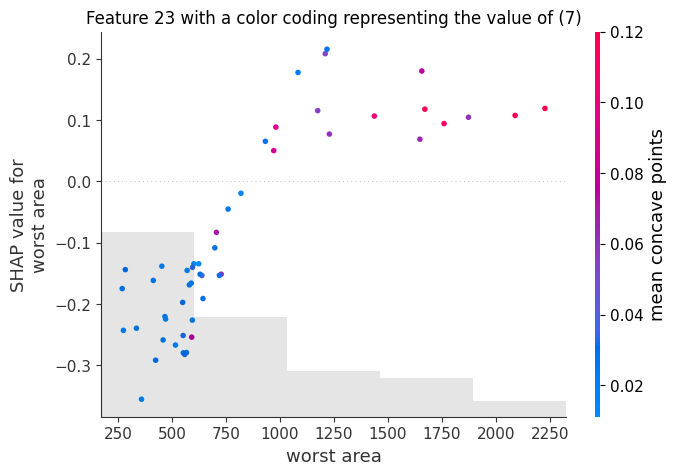

In [15]:
from tabpfn_extensions import interpretability

# Load example dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
n_samples = 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Initialize and train model
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)

### Feature selection

Feature selection is the process of selecting a subset of relevant features for use in model construction. It's useful for reducing model complexity, improving performance by removing noise, and decreasing training time. Here, we'll use Sequential Forward Selection (SFS), which starts with no features and iteratively adds the feature that most improves the model's performance.

The goal is to see if we can create a simpler, faster model with fewer features without a significant drop in accuracy.


In [16]:
from tabpfn_extensions import interpretability

# Load data
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize model
clf = TabPFNClassifier(n_estimators=1)

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf, X=X, y=y, n_features_to_select=2, feature_names=feature_names
)

# Print selected features
selected_features = [
    feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")


Selected features:
- worst perimeter
- worst smoothness


# Predictive Behavior of TabPFN <a name="behavior"></a>

In this section, we explore the behavior of predictions from TabPFN on various toy functions.

## Decision Boundary during Classification

First, let us inspect the decision boundary for different classifiers.
The decision bounds show how smoothly a model learns to transition between classes and how well it fits the data.

In the first cell, we create the data and code to plot the decision boundary. The second cell then generates the plot.

In [36]:
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay


# Toy functions that generate the data
def generate_circle(n_datapoints, radius, noise_factor):
    angles = np.linspace(0, 2 * np.pi, n_datapoints).T
    x = radius * np.cos(angles) + np.random.randn(n_datapoints) * noise_factor
    y = radius * np.sin(angles) + np.random.randn(n_datapoints) * noise_factor

    return np.stack([x, y]).T


def generate_concentric_cirlces(radii, num_points_per_circle, noise_factor=1 / 15):
    circles = []
    for r, num_points in zip(radii, num_points_per_circle):
        circles.append(generate_circle(num_points, r, noise_factor))

    return np.vstack(circles)


def generate_circle_data(num_points_per_circle, radii, noise_factor):
    radii = np.array(radii)
    circles_1 = generate_concentric_cirlces(radii, num_points_per_circle, noise_factor)
    circles_1 = np.hstack([circles_1, np.zeros((sum(num_points_per_circle), 1))])

    circles_2 = generate_concentric_cirlces(
        radii + 0.3, num_points_per_circle, noise_factor
    )
    circles_2 = np.hstack([circles_2, np.ones((sum(num_points_per_circle), 1))])

    circles = np.vstack([circles_1, circles_2])
    X, y = circles[:, :2], circles[:, 2]
    return X, y


# Generate the data
X_train, y_train = generate_circle_data(
    num_points_per_circle=[50, 100, 200], radii=[1, 2, 4], noise_factor=0.1
)


# Function for plotting
def plot_decision_boundary(ax, model, model_name):
    cmap = ListedColormap(["#FF0000", "#0000FF"])
    ax.set_title(model_name)
    DecisionBoundaryDisplay.from_estimator(
        model,
        X_train[:, :2],
        alpha=0.6,
        ax=ax,
        eps=0.2,
        grid_resolution=50,
        response_method="predict_proba",
        cmap=plt.cm.RdBu,
    )
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

In [37]:
from sklearn.gaussian_process import GaussianProcessClassifier
from catboost import CatBoostClassifier

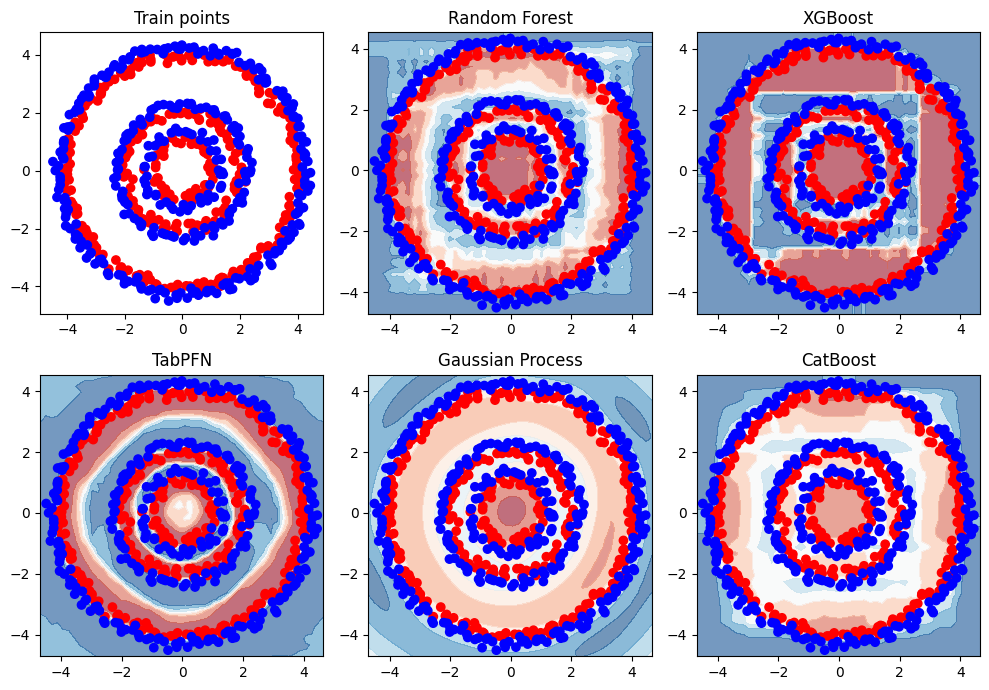

In [38]:
rf = RandomForestClassifier().fit(X_train[:, :2], y_train)
xgb = XGBClassifier().fit(X_train[:, :2], y_train)
tabpfn = TabPFNClassifier().fit(X_train[:, :2], y_train)
gp = GaussianProcessClassifier().fit(X_train, y_train)
catboost = CatBoostClassifier(verbose=0).fit(X_train, y_train)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Plot Train Points
ax_points = axes[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"])
)

# Plot Random Forest
ax_rf = axes[0, 1]
plot_decision_boundary(ax_rf, rf, "Random Forest")

# Plot XGBoost
ax_xgb = axes[0, 2]
plot_decision_boundary(ax_xgb, xgb, "XGBoost")

# Plot TabPFN
ax_tabpfn = axes[1, 0]
plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

# 绘制Gaussian Process决策边界
ax_gp = axes[1, 1]
plot_decision_boundary(ax_gp, gp, "Gaussian Process")

# 绘制CatBoost决策边界
ax_catboost = axes[1, 2]
plot_decision_boundary(ax_catboost, catboost, "CatBoost")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Sin Curve Fitting with Regression

Next, we investigate the curve-fitting behavior of the different models on a sin curve.

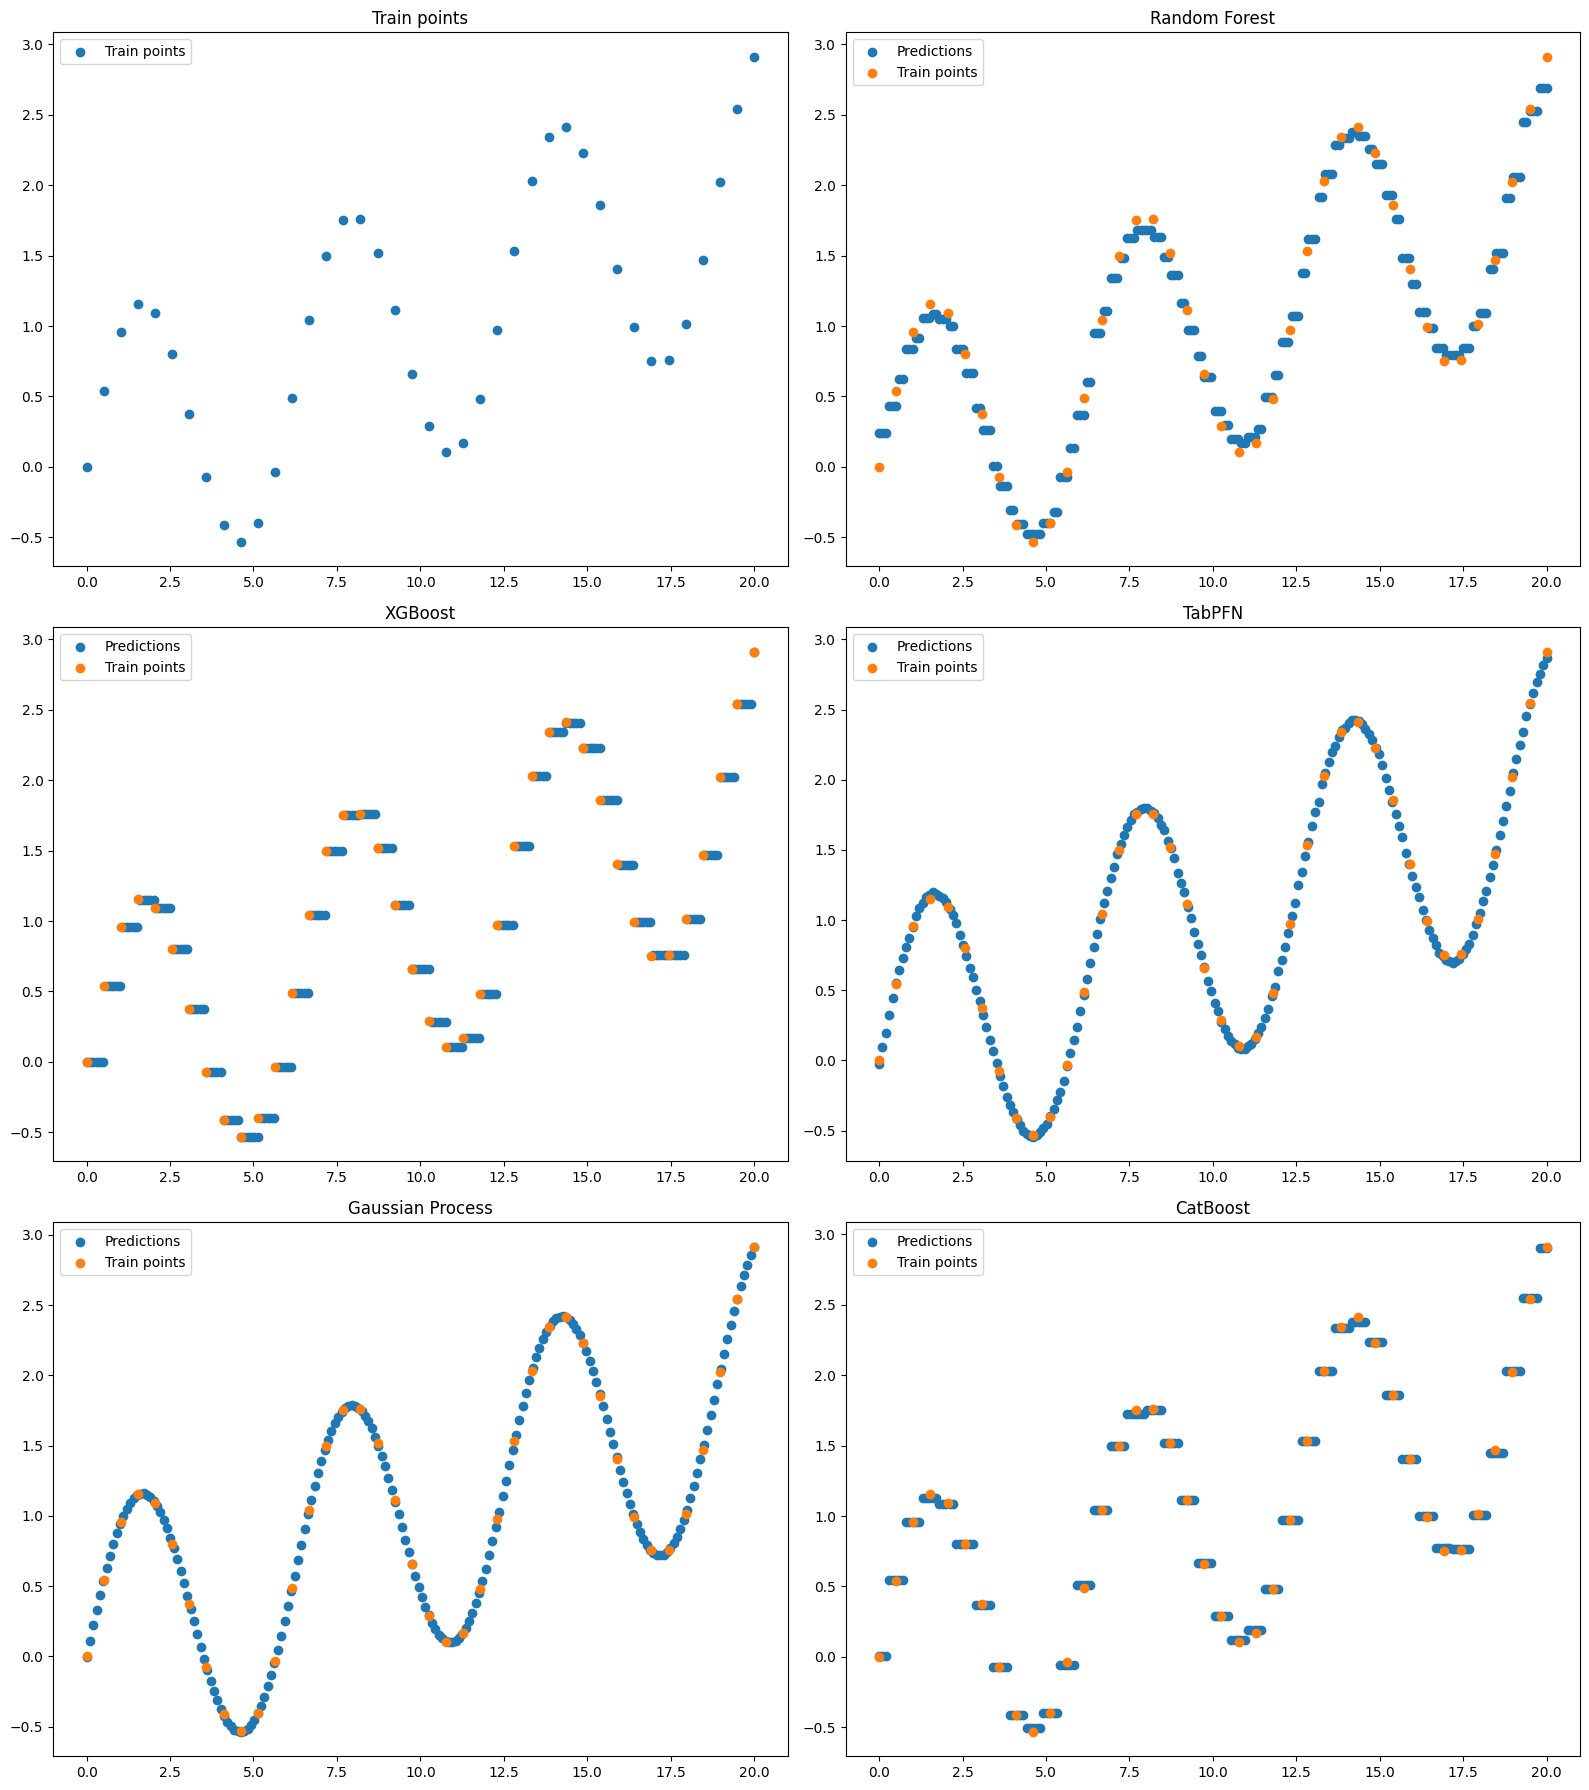

In [39]:
# Toy function to generate data
def generate_sinx_plus_x(N):
    x = np.linspace(0, 20, N)
    y = np.sin(x) + x / 10

    return x.reshape(-1, 1), y


# Utility function for plotting
def plot_predictions(ax, model, model_name):
    X_test = np.linspace(0, 20, 200).reshape(
        -1, 1
    )  # Predict for 200 points  between 0 and 20
    y_preds = model.predict(X_test)
    ax.set_title(model_name)
    ax.scatter(X_test, y_preds, label="Predictions")
    ax.scatter(X_train, y_train, label="Train points")
    ax.legend()


# Generate data
X_train, y_train = generate_sinx_plus_x(N=40)

# Fit Models
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state=42).fit(X_train, y_train)
catboost = CatBoostRegressor(verbose=0, random_state=42).fit(X_train, y_train)
gp = make_pipeline(StandardScaler(), GaussianProcessRegressor()).fit(X_train, y_train)

tabpfn = TabPFNRegressor()
tabpfn.fit(X_train, y_train)

# Create a 2x2 subplot layout
fig, axs = plt.subplots(3, 2, figsize=(16, 18))

# Plot train points
ax_points = axs[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train, y_train, label="Train points")
ax_points.legend()

# Plot predictions for Random Forest
ax_rf = axs[0, 1]
plot_predictions(ax_rf, rf, "Random Forest")

# Plot predictions for XGBoost
ax_xgb = axs[1, 0]
plot_predictions(ax_xgb, xgb, "XGBoost")

# Plot predictions for TabPFN
ax_tabpfn = axs[1, 1]
plot_predictions(ax_tabpfn, tabpfn, "TabPFN")

# Plot predictions for Gaussian Process
plot_predictions(axs[2, 0], gp, "Gaussian Process")

# Plot predictions for CatBoost
plot_predictions(axs[2, 1], catboost, "CatBoost")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Uncertainty of TabPFN / Quantile Regresison

---



TabPFN is trained to predict the distribution of the target variable and not just a single point. This is also the case for regression.

As a result, we natively obtain uncertainty for the predictions of TabPFN (without the need for a new model or repeating models for different quantiles).

In the following, we plot the uncertainty of TabPFN for a toy function with noise.

In [40]:
### Code to generate the plot (feel free to ignore)
def plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, color_multiplier=5):
    all_quantiles = preds["quantiles"]
    y = np.array(all_quantiles)  # shape of y: (9, number of samples)

    # Calculate the maximum and minimum values in y
    y_max = np.max(y, axis=0)
    y_min = np.min(y, axis=0)

    # Calculate the widths of each quantile bin
    quantile_bin_widths = np.diff(
        y, axis=0
    )  # shape of quantile_bin_widths: (8, number of samples)

    # Normalize the bin widths for a given x
    per_x_normalized_bin_widths = (quantile_bin_widths) / (y_max - y_min)

    # Plotting
    num_bins, num_data_points = (
        per_x_normalized_bin_widths.shape[0],
        per_x_normalized_bin_widths.shape[1],
    )
    rect_width = (
        x_test[1] - x_test[0]
    ).squeeze()  # assuming the x query points are equally spaced out

    for i in range(num_data_points):
        for j in range(num_bins):
            quantile_bin_widths[j, i]
            rect = plt.Rectangle(
                xy=(x_test[i][0] - rect_width / 2, y[j, i]),
                width=rect_width,
                height=quantile_bin_widths[j, i],
                facecolor=plt.cm.viridis(
                    per_x_normalized_bin_widths[j, i] * color_multiplier
                ),
                edgecolor="none",
            )
            ax.add_patch(rect)

    # Set limits and labels
    ax.plot(x, y_line, label="True line", color="blue")
    ax.set_xlim(min(x_test) - 1, max(x_test) + 1)
    ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # ax.plot(x, y, label='True line', color='blue')
    ax.scatter(x, y_noisy, label="Noisy data", color="red", s=10)

    plt.title("TabPFN Regression Uncertainty")
    plt.show()


# Generate Data
def generate_line_with_heteroscedastic_noise(
    m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1
):
    x = np.linspace(x_start, x_end, num_points)
    noise = np.random.randn(num_points)
    y = m * x
    y_noisy = y + (noise * noise_factor * x)

    return x.reshape(-1, 1), y, y_noisy


def generate_line_with_heteroscedastic_noise_with_gap(
    m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1
):
    extra_points = num_points // 3
    x, y, y_noisy = generate_line_with_heteroscedastic_noise(
        m, num_points + extra_points, x_start, x_end, noise_factor
    )
    a = np.arange(num_points + extra_points)
    idx = np.where((a < num_points / 3) | (a > num_points / 3 + extra_points))
    return x[idx], y[idx], y_noisy[idx]


x, y_line, y_noisy = generate_line_with_heteroscedastic_noise_with_gap(0.8)
x_test = np.linspace(0, 100, 200).reshape(-1, 1)

In [41]:
reg = TabPFNRegressor()
reg.fit(x, y_noisy)
preds = reg.predict(x_test, output_type="full")

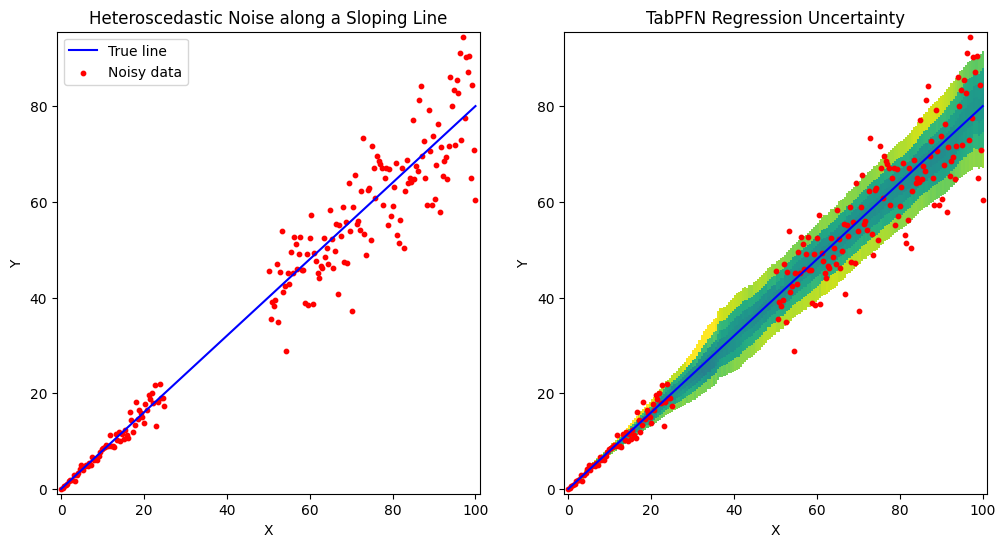

In [42]:
fig = plt.figure(figsize=(12, 6))

# Plot the original data
ax = fig.add_subplot(121)
ax.plot(x, y_line, label="True line", color="blue")
ax.scatter(x, y_noisy, label="Noisy data", color="red", s=10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(min(x) - 1, max(x) + 1)
ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
ax.set_title("Heteroscedastic Noise along a Sloping Line")
ax.legend()

# plot the uncertainty estimates obtained from TabPFN
ax = fig.add_subplot(122)
plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, color_multiplier=5)